In [2]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
from typing import Literal

class Flow(nn.Module):
    def __init__(self, d: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d + 1, hidden),  # +1 for time t
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, d)       # predict velocity in R^d
        )

    def forward(self, t: torch.Tensor, x_t: torch.Tensor) -> torch.Tensor:
        # t: (B,1), x_t: (B,d)
        inp = torch.cat([t, x_t], dim=-1)  # (B, d+1)
        return self.net(inp)               # (B, d)

    @torch.no_grad()
    def step(self, x: torch.Tensor, t: torch.Tensor, dt: float,
             method: Literal["euler", "heun"]="heun") -> torch.Tensor:
        """Advance x by dt along the learned velocity field at time t."""
        if method == "euler":
            v = self.forward(t, x)
            return x + dt * v

        # Heun (RK2): better stability for same step size
        v1 = self.forward(t, x)
        x_pred = x + dt * v1
        v2 = self.forward(t + dt, x_pred)
        return x + 0.5 * dt * (v1 + v2)

# Data Processing

In [7]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('data_price_daily.csv')

# Drop rows with any NaN values and remove the date column
x_1 = df.dropna().drop(columns=["date"]).to_numpy(dtype=np.float32)

print("Shape of x_1:", x_1.shape)  # (998, 24)

Shape of x_1: (998, 24)


# Training

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

x_1_tensor = torch.from_numpy(x_1).to(device=device, dtype=dtype)
BATCH_SIZE = 128
dataset = TensorDataset(x_1_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

D = x_1.shape[1]          # D = 24 for your data
flow = Flow(D).to(device)   # or Flow(d=D) if that's your ctor
loss_fn = nn.MSELoss()

# --- load checkpoint ---
ckpt = torch.load("checkpoint_step_2500000.pt", map_location=device)
flow.load_state_dict(ckpt["model"])

# create optimizer, then restore its state (so momentum, etc. resume)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
if "optimizer" in ckpt:
    optimizer.load_state_dict(ckpt["optimizer"])
    # optional: force a new LR even after loading:
    for g in optimizer.param_groups:
        g["lr"] = 1e-3

# resume from next step to avoid repeating the saved one
starting_step = int(ckpt.get("step", -1))

losses = deque(maxlen=1000)

flow.train()
for step in range(starting_step, 5_000_000):
    for (x1_batch,) in loader:
        B, _ = x1_batch.shape

        # sample x0 and times
        x0 = torch.randn(B, D, device=device, dtype=dtype)
        t  = torch.rand(B, 1, device=device, dtype=dtype)

        # linear interpolant and target velocity
        x_t  = (1 - t) * x0 + t * x1_batch
        dx_t = x1_batch - x0

        # model step
        optimizer.zero_grad(set_to_none=True)
        v_pred = flow(t=t, x_t=x_t)               # should return (B, D)
        loss = loss_fn(v_pred, dx_t.detach())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())

    if (step + 1) % 100 == 0:
        print(f"step {step+1}: loss={sum(losses)/len(losses):.6f}")

    if (step + 1) % 500_000 == 0:
        torch.save({
            "model": flow.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }, f"checkpoint_step_{step+1}.pt")

step 1000100: loss=9905.633789
step 1000200: loss=5561.851562
step 1000300: loss=5543.406250
step 1000400: loss=1855.409302
step 1000500: loss=2729.147461
step 1000600: loss=1530.438843
step 1000700: loss=940.855042
step 1000800: loss=3435.233154
step 1000900: loss=3320.456299
step 1001000: loss=2921.109131
step 1001100: loss=9379.754883
step 1001200: loss=5274.022461
step 1001300: loss=9178.198242
step 1001400: loss=2975.862305
step 1001500: loss=943.467590
step 1001600: loss=3737.241455
step 1001700: loss=2247.295898
step 1001800: loss=12405.784180
step 1001900: loss=1247.328857
step 1002000: loss=6936.399902
step 1002100: loss=2148.463135
step 1002200: loss=3729.320312
step 1002300: loss=2273.936279
step 1002400: loss=1117.253052
step 1002500: loss=6820.484863
step 1002600: loss=6025.696777
step 1002700: loss=3256.639404
step 1002800: loss=3122.746338
step 1002900: loss=4477.698730
step 1003000: loss=1980.974609
step 1003100: loss=1857.989624
step 1003200: loss=2221.431885
step 1003

KeyboardInterrupt: 

# Load trained model

In [8]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

x_1_tensor = torch.from_numpy(x_1).to(device=device, dtype=dtype)
BATCH_SIZE = 128
dataset = TensorDataset(x_1_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

D = x_1.shape[1]          # D = 24 for your data
flow = Flow(D).to(device)   # or Flow(d=D) if that's your ctor
loss_fn = nn.MSELoss()

# --- load checkpoint ---
ckpt = torch.load("checkpoint_step_7500000.pt", map_location=device)
flow.load_state_dict(ckpt["model"])

<All keys matched successfully>

# Plot the distribution

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- sampler (Euler) ----------
@torch.no_grad()
def sample_flow(flow, n, D, steps=200, device="cpu", dtype=torch.float32, batch_size=8192):
    """Generate n samples by integrating dx/dt = v_theta(t, x) from t=0->1."""
    flow.eval()
    out = []
    dt = 1.0 / steps
    for start in range(0, n, batch_size):
        bs = min(batch_size, n - start)
        x = torch.randn(bs, D, device=device, dtype=dtype)
        for i in range(steps):
            t = torch.full((bs, 1), i / steps, device=device, dtype=dtype)
            v = flow(t=t, x_t=x)      # your model's forward(t, x_t)
            x = x + dt * v            # Euler step
        out.append(x)
    return torch.cat(out, dim=0)

def _to_np(x):
    return x if isinstance(x, np.ndarray) else x.detach().cpu().numpy()

def plot_dims(dims, n_gen=None, steps=200, bins=80, density=True,
              xlim=None, qlim=None, logx=False, symlog=False, linthresh=1.0):
    """
    dims   : list of dims to plot, e.g. [0] or [0,5,12]
    xlim   : (lo, hi) manual range for x-axis
    qlim   : (qlo, qhi) clip by quantiles, e.g. (0.01, 0.99)
    logx   : True -> log x-axis (data must be > 0)
    symlog : True -> symmetric log x-axis (works with negatives/zeros)
    """
    global x_1, flow, D, device, dtype

    # real & generated
    x_real = _to_np(x_1)
    if n_gen is None: n_gen = len(x_real)
    with torch.no_grad():
        flow.eval()
        dt = 1/200 if steps is None else 1/steps
        x = torch.randn(n_gen, D, device=device, dtype=dtype)
        for i in range(steps):
            t = torch.full((n_gen,1), i/steps, device=device, dtype=dtype)
            v = flow(t=t, x_t=x)
            x = x + dt * v
        x_gen = x.detach().cpu().numpy()

    for d in dims:
        a = x_real[:, d].astype(np.float64)
        b = x_gen[:,  d].astype(np.float64)
        both = np.concatenate([a, b])

        # determine plotting range
        lo, hi = (np.min(both), np.max(both)) if xlim is None else xlim
        if qlim is not None:
            lo = np.quantile(both, qlim[0])
            hi = np.quantile(both, qlim[1])

        # build shared bins for fair overlay
        if logx:
            # need strictly positive support
            pos = both[both > 0]
            if len(pos) == 0:
                raise ValueError("logx=True but data has no positive values; use symlog instead.")
            lo_p = max(lo, np.min(pos))
            hi_p = max(lo_p * (1 + 1e-6), hi)
            bins_arr = np.logspace(np.log10(lo_p), np.log10(hi_p), bins + 1)
        else:
            bins_arr = np.linspace(lo, hi, bins + 1)

        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(a, bins=bins_arr, density=density, alpha=0.5, label=f"real dim {d}")
        ax.hist(b, bins=bins_arr, density=density, alpha=0.5, label=f"gen  dim {d}")
        ax.set_xlim(lo, hi)

        if logx:
            ax.set_xscale("log")
        elif symlog:
            ax.set_xscale("symlog", linthresh=linthresh)

        r_mu, r_sd = float(np.mean(a)), float(np.std(a))
        g_mu, g_sd = float(np.mean(b)), float(np.std(b))
        ax.set_xlabel(f"x[:, {d}]")
        ax.set_ylabel("density" if density else "count")
        ax.set_title(f"Distribution — dim {d}\nReal μ/σ={r_mu:.3f}/{r_sd:.3f} | Gen μ/σ={g_mu:.3f}/{g_sd:.3f}")
        ax.legend()
        fig.tight_layout()
        plt.show()

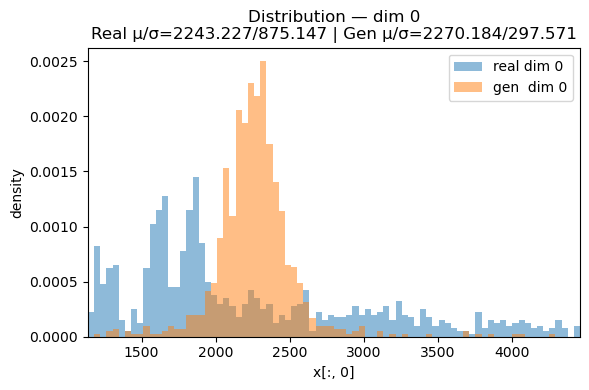

In [43]:
plot_dims([0], qlim=(0.01, 0.99))

# Plot the distribution of the return

In [44]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- sampler (Euler) ----------
@torch.no_grad()
def sample_flow(flow, n, D, steps=200, device="cpu", dtype=torch.float32, batch_size=8192):
    """Generate n synthetic samples from the flow by integrating dx/dt = v_theta(t, x) from t=0->1."""
    flow.eval()
    out = []
    dt = 1.0 / steps
    for start in range(0, n, batch_size):
        bs = min(batch_size, n - start)
        x = torch.randn(bs, D, device=device, dtype=dtype)
        for i in range(steps):
            t = torch.full((bs, 1), i / steps, device=device, dtype=dtype)
            v = flow(t=t, x_t=x)
            x = x + dt * v
        out.append(x)
    return torch.cat(out, dim=0)

# ---------- returns helpers ----------
def _to_np(x):
    if isinstance(x, np.ndarray):
        return x
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    raise TypeError("Expected numpy array or torch tensor")

def compute_returns(arr, method="auto", eps=1e-8):
    """
    arr: shape (T, D) assumed time along axis 0.
    method: 'auto' -> 'log' if all positive, else 'simple'
            'log'  -> log((x_t+eps)/(x_{t-1}+eps))
            'simple' -> (x_t - x_{t-1}) / max(|x_{t-1}|, eps)
    returns: shape (T-1, D)
    """
    x = np.asarray(arr, dtype=np.float64)
    if method == "auto":
        method = "log" if np.all(x > 0) else "simple"
    if method == "log":
        r = np.log((x[1:] + eps) / (x[:-1] + eps))
    elif method == "simple":
        denom = np.maximum(np.abs(x[:-1]), eps)
        r = (x[1:] - x[:-1]) / denom
    else:
        raise ValueError("method must be 'auto', 'log', or 'simple'")
    return r

# ---------- main plotting utility ----------
def plot_return_distribution(dims=None, n_gen=None, steps=200, method="auto",
                             bins=120, density=True, qlim=(0.005, 0.995),
                             xlim=None, logx=False, symlog=False, linthresh=1e-3):
    """
    dims: list of column indices to include (e.g., [0] or [0,5,12]). None -> all.
    n_gen: number of synthetic rows to sample (default: len(x_1))
    method: 'auto' | 'log' | 'simple' (see compute_returns)
    qlim: (q_lo, q_hi) quantile clip for x-axis; set to None to disable
    xlim: manual x-axis (lo, hi); applied after qlim
    logx/symlog: set x-scale; symlog works with zeros/negatives
    """
    global x_1, flow, D, device, dtype

    x_real = _to_np(x_1)                         # (T, D)
    if dims is None:
        dims = list(range(x_real.shape[1]))
    x_real = x_real[:, dims]

    # generate synthetic with same number of rows by default
    T = x_real.shape[0]
    if n_gen is None:
        n_gen = T
    x_gen = sample_flow(flow, n=n_gen, D=D, steps=steps, device=device, dtype=dtype).cpu().numpy()
    x_gen = x_gen[:, dims]

    # compute returns along time (rows)
    r_real = compute_returns(x_real, method=method)   # (T-1, len(dims))
    r_gen  = compute_returns(x_gen,  method=method)

    # flatten across dims for a single pooled distribution
    rr = r_real.reshape(-1)
    rg = r_gen.reshape(-1)

    # determine x-axis range
    both = np.concatenate([rr, rg])
    lo, hi = np.min(both), np.max(both)
    if qlim is not None:
        lo = np.quantile(both, qlim[0])
        hi = np.quantile(both, qlim[1])
    if xlim is not None:
        lo, hi = xlim

    # shared bins
    if logx:
        pos = both[both > 0]
        if len(pos) == 0:
            raise ValueError("logx=True but returns contain no positive values; use symlog.")
        lo_p = max(lo, np.min(pos))
        hi_p = max(lo_p * (1 + 1e-12), hi)
        bins_arr = np.logspace(np.log10(lo_p), np.log10(hi_p), bins + 1)
    else:
        bins_arr = np.linspace(lo, hi, bins + 1)

    # plot
    plt.figure(figsize=(7,4))
    plt.hist(rr, bins=bins_arr, density=density, alpha=0.5, label="real returns")
    plt.hist(rg, bins=bins_arr, density=density, alpha=0.5, label="generated returns")
    plt.xlim(lo, hi)
    if logx:
        plt.xscale("log")
    elif symlog:
        plt.xscale("symlog", linthresh=linthresh)

    r_mu, r_sd = rr.mean(), rr.std()
    g_mu, g_sd = rg.mean(), rg.std()
    plt.xlabel("return")
    plt.ylabel("density" if density else "count")
    plt.title(f"Return distribution (dims={dims}, method={method})\n"
              f"Real μ/σ={r_mu:.4g}/{r_sd:.4g} | Gen μ/σ={g_mu:.4g}/{g_sd:.4g}")
    plt.legend()
    plt.tight_layout()
    plt.show()


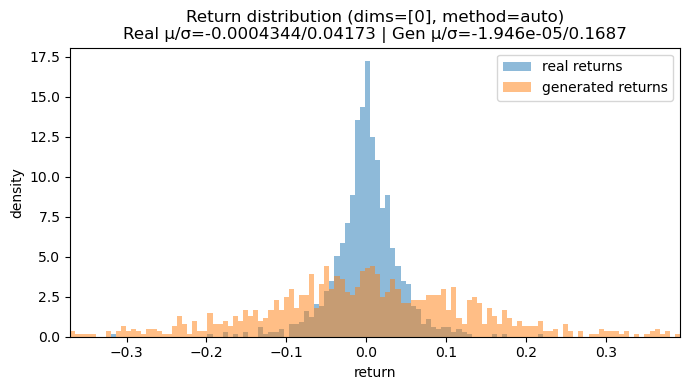

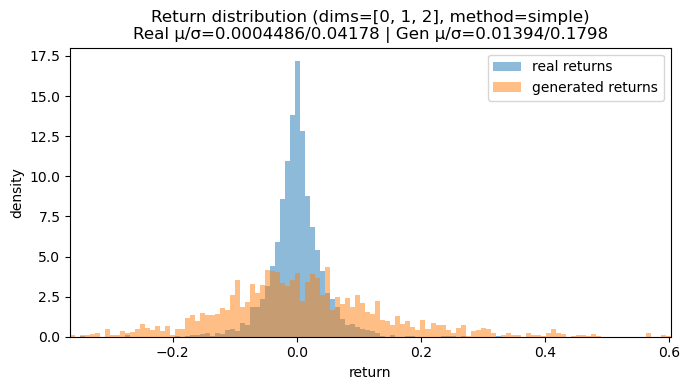

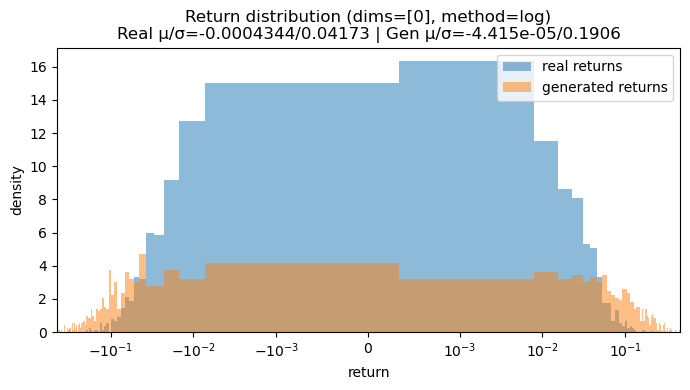

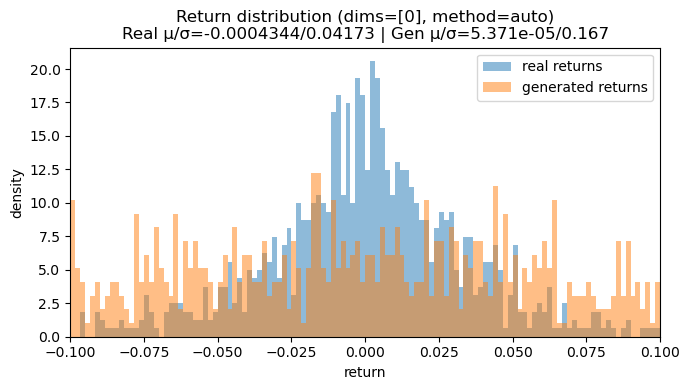

In [45]:
# Single dimension (e.g., 0) with robust zoom:
plot_return_distribution(dims=[0], method="auto", qlim=(0.01, 0.99))

# Multiple dimensions pooled together:
plot_return_distribution(dims=[0, 1, 2], method="simple", qlim=(0.005, 0.995))

# If your data is strictly positive and you want log-returns:
plot_return_distribution(dims=[0], method="log", qlim=(0.01, 0.99), symlog=True, linthresh=1e-3)

# Manual x-axis range:
plot_return_distribution(dims=[0], method="auto", xlim=(-0.1, 0.1))


# Generate trading data

In [9]:
import os
import numpy as np
import pandas as pd
import torch

# ---- config ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

D = x_1.shape[1]                 # feature dimension
N_SAMPLES = 100_000              # how many samples to generate
STEPS     = 200                  # Euler steps for integration
BATCH     = 8192                 # sampling batch size

CKPT_PATH = "C:\\Users\\qwer9\\OneDrive\\桌面\\Generated-Trading-Data\\checkpoint_step_7500000.pt"  # change if needed
CSV_PATH  = "C:\\Users\\qwer9\\OneDrive\\桌面\\Generated-Trading-Data\\generated_samples.csv"       # where to save

# ---- model init & load ----
flow = Flow(D).to(device)  # if your ctor is Flow(d=D), change to Flow(d=D)

state = torch.load(CKPT_PATH, map_location=device)
flow.load_state_dict(state["model"] if "model" in state else state)
flow.eval()

# ---- sampler (Euler) ----
@torch.no_grad()
def sample_flow(flow, n, D, steps=200, device="cpu", dtype=torch.float32, batch_size=8192):
    """Integrate dx/dt = v_theta(t, x) from t=0->1 to sample n points."""
    out = []
    dt = 1.0 / steps
    for start in range(0, n, batch_size):
        bs = min(batch_size, n - start)
        x = torch.randn(bs, D, device=device, dtype=dtype)
        for i in range(steps):
            t = torch.full((bs, 1), i / steps, device=device, dtype=dtype)
            v = flow(t=t, x_t=x)     # model predicts velocity
            x = x + dt * v           # Euler step
        out.append(x)
    return torch.cat(out, dim=0)

# (optional) reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

# ---- generate & save ----
samples = sample_flow(flow, n=N_SAMPLES, D=D, steps=STEPS, device=device, dtype=dtype)
samples_np = samples.detach().cpu().numpy()

# If you trained with a scaler/normalizer, invert here:
# samples_np = scaler.inverse_transform(samples_np)

os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
cols = [f"dim_{i}" for i in range(D)]
pd.DataFrame(samples_np, columns=cols).to_csv(CSV_PATH, index=False)
print(f"Saved {N_SAMPLES} samples to: {CSV_PATH}")


Saved 100000 samples to: C:\Users\qwer9\OneDrive\桌面\Generated-Trading-Data\generated_samples.csv
